# Vehicle Detection and Tracking

In [17]:
import cv2
import glob
import imp
import ipywidgets
from IPython import display
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import time

# helper modules
import libp5.dataset as dataset
import libp5.feature_extraction as feature_extraction
import libp5.image_utils as image_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Vehicle and Non-Vehicle Datasets

I have downloaded the vehicle and non-vehicle data sets provided in the module. These do not include the two larger optional datasets.

image shape: (64, 64, 3)
image type: uint8
Total car images: 8792
Total non-car images: 8968


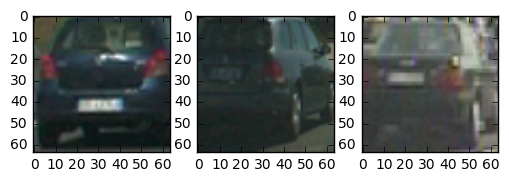

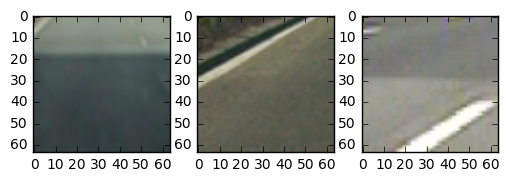

In [23]:
# get list of vehicle image files and list of non-vehicle image files
vehicles, non_vehicles = dataset.get_vehicle_classification_data()

# image attributes
example_image = np.uint8(mpimg.imread(vehicles[0])*255)
print("image shape: {}".format(example_image.shape))
print("image type: {}".format(example_image.dtype))

# 64x64x3
image_shape = example_image.shape

print("Total car images: {}".format(len(vehicles)))
print("Total non-car images: {}".format(len(non_vehicles)))

# plot vehicle images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
img1, img2, img3 = [image_utils.imread(i) for i in vehicles[:3]]
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)

# plot non-vehicle images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
img1, img2, img3 = [image_utils.imread(i) for i in non_vehicles[:3]]
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)

At a high level the dataset looks balanced with approximately 50% of the data allocated to each class.

### Color Space Examination

One of the features that will be used by the classifier is the histogram of each channel of the image. By default the image is in the "RGB" color space but that might not be the best color space for this task. In this next section I have created an interactive plot that allows for quick comparisons between the histograms of car and non-car images in different color spaces. The color space that has the most distinguishing features will be used for classification.

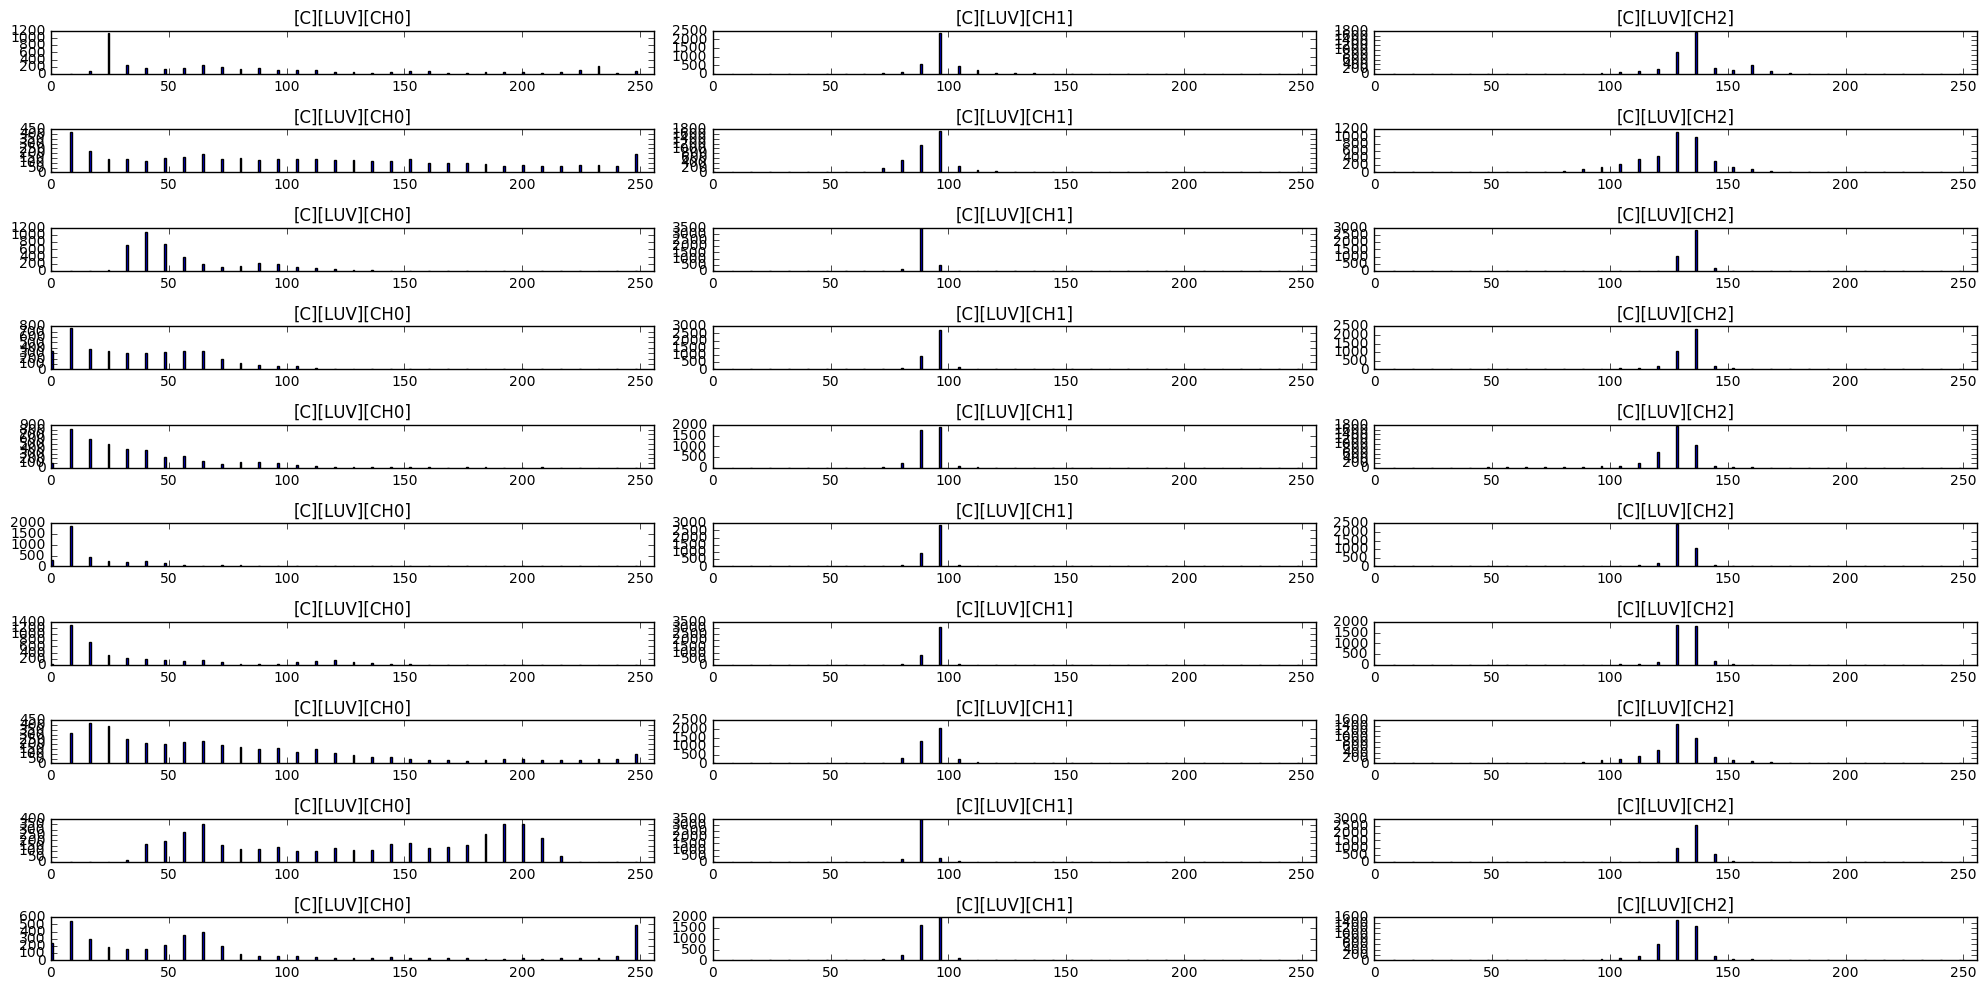

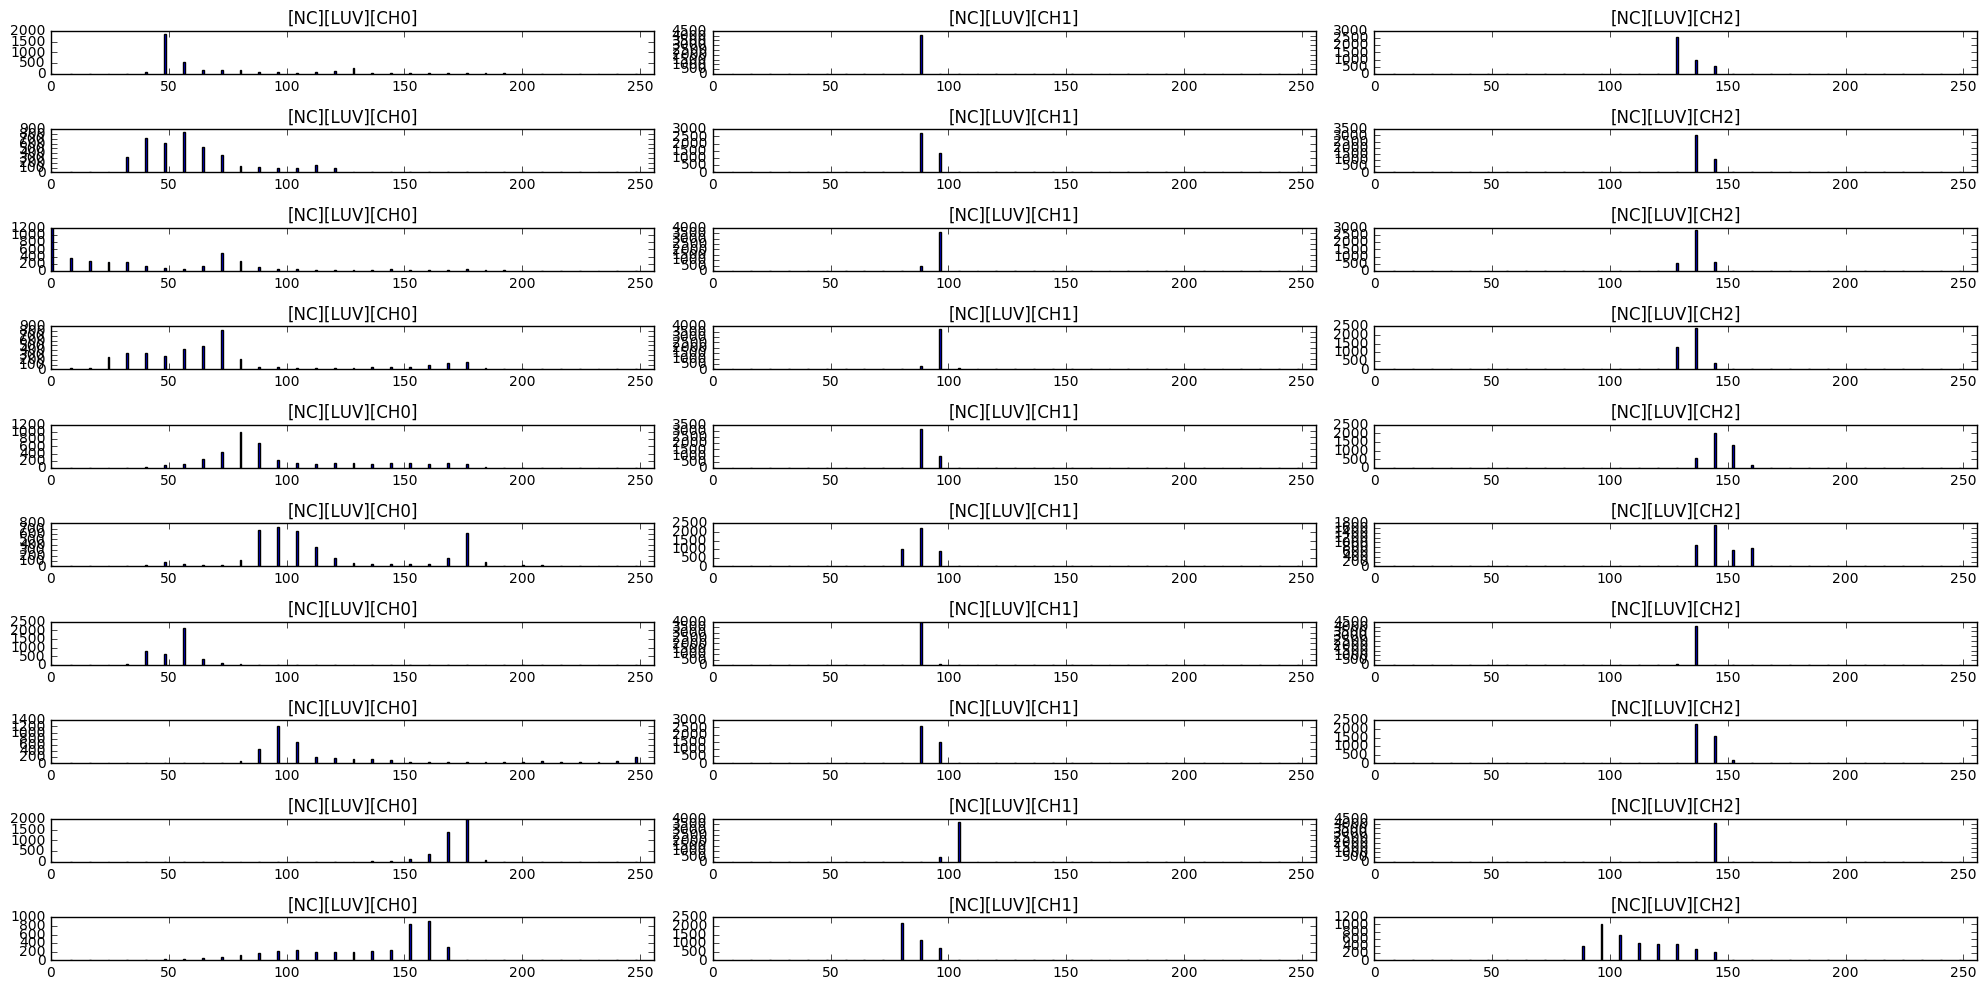

In [24]:
# hyperparameters
hist_bins = 32
bin_range = (0,256)

def examine_image(img, car=True):
    fig = plt.figure()
    plt.imshow(img)
    
    label = "C" if car else "NC"

    fig, axes = plt.subplots(6,3, figsize=(10,10))
    for r, cs in enumerate(["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]):
        cvt = feature_extraction.cvt_color(img, cs)
        for ch in range(3):
            # select subplot
            ax = axes[r,ch]
            # compute histogram of channel
            counts, edges = np.histogram(cvt[:,:,ch], bins=hist_bins, range=bin_range)
            # plot histogram
            ax.bar(left=edges[:-1], height=counts)
            # set subplot title
            ax.set_title("[{}][{}][Ch{}]".format(label, cs, ch+1))
    fig.tight_layout()

def compare_color_spaces(n_car, n_not_car, cspace):
    plt.close('all')
    
    # randomly select images
    c_r_idx = np.random.randint(0, len(vehicles)-1, size=(n_car,))
    nc_r_idx = np.random.randint(0, len(non_vehicles)-1, size=(n_not_car,))
    
    # plot histogram of car images
    fig, axes = plt.subplots(n_car, 3, figsize=(n_car*2, 10))
    for row, img in enumerate([image_utils.imread(vehicles[i]) for i in c_r_idx]):
        cvt = feature_extraction.cvt_color(img, cspace)
        for ch in range(3):
            ax = axes[row, ch]
            counts, edges = np.histogram(cvt[:,:,ch], bins=32, range=(0,256))
            ax.bar(left=edges[:-1], height=counts)
            ax.set_title("[C][{}][CH{}]".format(cspace, ch))
            ax.set_xlim((0,256))
    fig.tight_layout()
    
    # plot histogram of non-car images
    fig, axes = plt.subplots(n_not_car, 3, figsize=(n_not_car*2, 10))
    for row, img in enumerate([image_utils.imread(non_vehicles[i]) for i in nc_r_idx]):
        cvt = feature_extraction.cvt_color(img, cspace)
        for ch in range(3):
            ax = axes[row, ch]
            counts, edges = np.histogram(cvt[:,:,ch], bins=32, range=(0,256))
            ax.bar(left=edges[:-1], height=counts)
            ax.set_title("[NC][{}][CH{}]".format(cspace, ch))
            ax.set_xlim((0,256))
    fig.tight_layout()


ipywidgets.interact_manual(compare_color_spaces, 
                           n_car=(1,20), 
                           n_not_car=(1,20), 
                           cspace=ipywidgets.Dropdown(options=("RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb")))

In the above section I have created an interactive plot that allows for quickly changing the color space, number of cars, and number of non-cars to evaluate. The "LUV" color space looks promising. Cars generally have a uniform distribution in the L (achromatic channel) while non-cars are less consistent. This could prove to be a good feature for the classifier. The following colorspaces also share this property YUV, YCrCb.

### Histogram of Oriented Gradients

The second feature set is going to be the histogram of oriented gradients for the image. In this section I have created a interactive plot to help identify the best parameters. Ideally, I want to select the parameters that provide a balance between performance and the size of the feature vector. 

Here are the methods I use for computing the hot features.

```python
def apply_hog(img, orient, pix_per_cell, cell_per_block,
              vis=False, feature_vec=True):
    """
    Computes histogram of oriented gradients feature vector from image.

    :param img: (2D ndarray) source image
    :param orient: (int) number of orientation bins
    :param pix_per_cell: (int) size of cell in which HOG is computed
    :param cell_per_block: (int) size of cell block used for nomalization
    :param vis: (bool) return image for visualization
    :param feature_vec: (bool) ravel HOG feature
    :return: (1-tuple or 2-tuple) feature vector, (optional) visualization image
    """
    # Call with two outputs if vis==True
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, hog_channel):
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(apply_hog(img[:, :, channel],
                                          orient, pix_per_cell, cell_per_block,
                                          vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = apply_hog(img[:, :, hog_channel], orient,
                                 pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    return hog_features
```

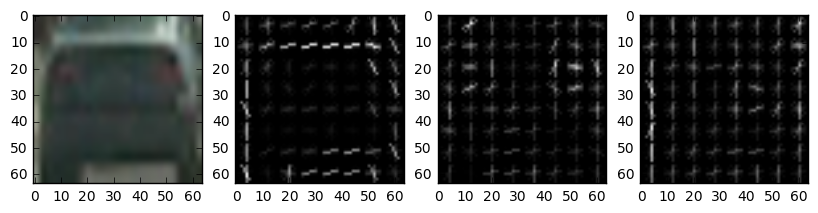

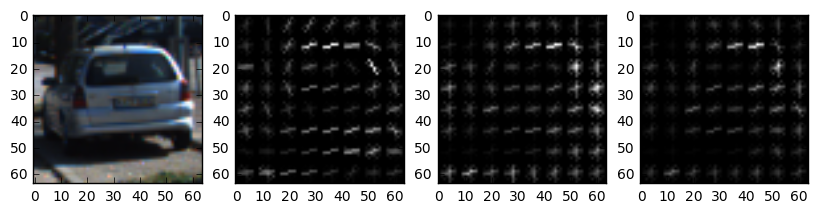

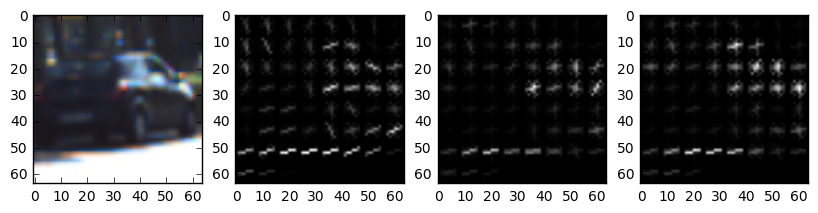

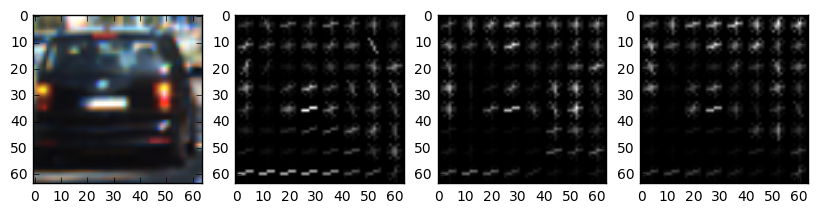

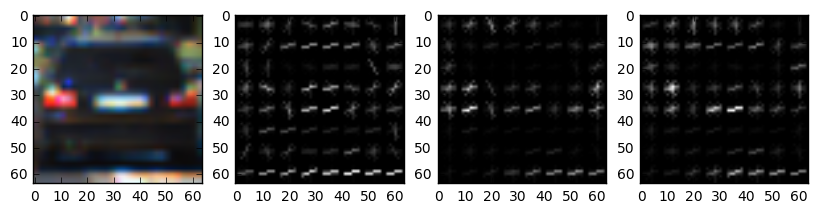

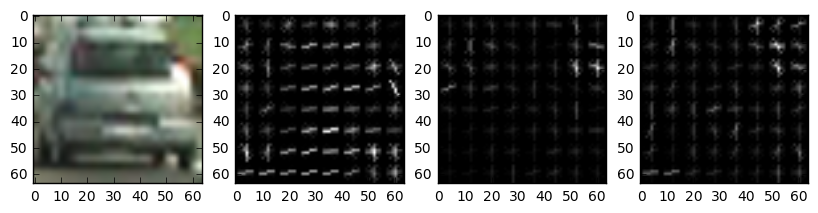

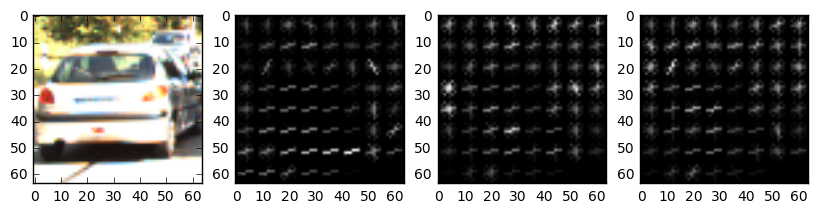

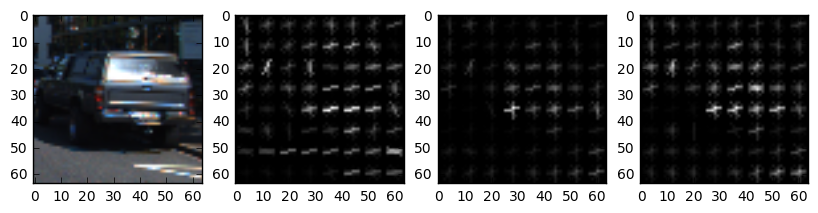

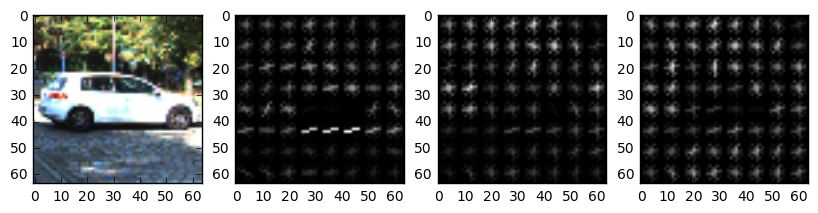

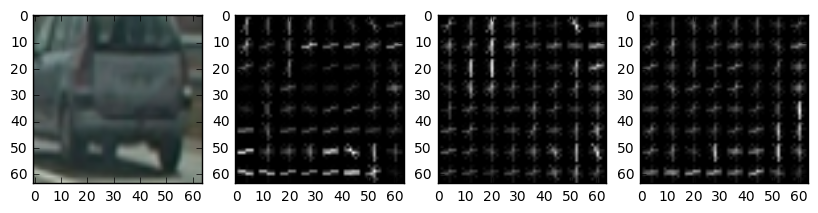

In [25]:
def compare_hog_parameters(n_car, orient, pix_per_cell, cell_per_block, cspace, vis=True):
    plt.close('all')
    
    # randomly select images
    c_r_idx = np.random.randint(0, len(vehicles)-1, size=(n_car,))
    
    for img in [image_utils.imread(vehicles[i]) for i in c_r_idx]:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))
        # convert image to target color space
        cvt = feature_extraction.cvt_color(img, cspace)
        # original image
        ax1.imshow(img)
        # plot hog visualization first channel
        ax2.imshow(feature_extraction.apply_hog(cvt[:,:,0], orient, pix_per_cell, cell_per_block, vis=vis)[1], cmap="gray")
        # plot hog visualization second channel
        ax3.imshow(feature_extraction.apply_hog(cvt[:,:,1], orient, pix_per_cell, cell_per_block, vis=vis)[1], cmap="gray")
        # plot hog visualization third channel
        ax4.imshow(feature_extraction.apply_hog(cvt[:,:,2], orient, pix_per_cell, cell_per_block, vis=vis)[1], cmap="gray")
        
ipywidgets.interact_manual(compare_hog_parameters, 
                           n_car=(1,20),
                           orient=(4,12), 
                           pix_per_cell=(2,32), 
                           cell_per_block=(2,32), 
                           cspace=ipywidgets.Dropdown(options=("RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb")),
                           vis=True)

## Train Linear Support Vector Machine Classifier using features

I am going to use the support vector machine for classification. The parameters for the spatial, color histograms and hog features will be the same as those above initially and will be tuned empiraclly until a desirable outcome is achieved. 

The methods used to compute the combined feature vectors from the images is provided below.

```python
def extract_feature(image, cspace, spatial_size, hist_bins, hist_range, orient, pix_per_cell, cell_per_block,
                    hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Returns concatenated spatial, color histogram, and hog feature vector for
    image.

    This method implements the feature extraction pipeline. This implemented
    in the following manner.

        1. Convert image to specified color space.
        2. Compute spatial feature vector.
        3. Compute color histogram feature vector.
        4. Compute hog feature vector.
        5. Concatenate feature vectors.

    :param image: (ndarray) 3-channel image
    :param cspace: (str) color space
    :param spatial_size: (int) resized image dimensions
    :param hist_bins: (int) number of bins for color histograms
    :param hist_range: (2-tuple) min, max bin values for color histograms
    :param orient: (int) number of orientation bins for HOG
    :param pix_per_cell: (int) dimensions of cell for HOG
    :param cell_per_block: (int) dimensions of normalization block for HOG
    :param hog_channel: (int or str) color channel to use for HOG or 'ALL' to use all channels.
    :param spatial_feat: (bool) compute spatial feature
    :param hist_feat: (bool) compute histogram feature
    :param hog_feat: (bool) compute HOG feature
    :return: (1D ndarray) image feature vector
    """
    feature_image = image.astype(np.uint8)
    feature_image = cvt_color(feature_image, cspace)

    spatial_features = np.array([])
    if spatial_feat:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)

    hist_features = np.array([])
    if hist_feat:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    hog_features = np.array([])
    if hog_feat:
        # Apply apply_hog() to get hog features
        hog_features = get_hog_features(feature_image, orient, pix_per_cell, cell_per_block, hog_channel)

    combined_features = np.concatenate((spatial_features, hist_features, hog_features))

    return combined_features


def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                         hist_bins=32, hist_range=(0, 256), orient=9,
                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
                         spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Returns list of feature vectors of images.

    This method applies extract_feature to each image in the list and returns
    a list of the feature vectors.

    :param imgs: (list) image filenames (must be valid!)
    :param cspace: (str) color space
    :param spatial_size: (int) resized image dimensions
    :param hist_bins: (int) number of bins for color histograms
    :param hist_range: (2-tuple) min, max bin values for color histograms
    :param orient: (int) number of orientation bins for HOG
    :param pix_per_cell: (int) dimensions of cell for HOG
    :param cell_per_block: (int) dimensions of normalization block for HOG
    :param hog_channel: (int or str) color channel to use for HOG or 'ALL' to use all channels.
    :return: (list) image feature vectors
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = image_utils.imread(file)

        # compute and combine features into single feature vector
        combined_features = extract_feature(image, cspace, spatial_size,
                                            hist_bins, hist_range, orient,
                                            pix_per_cell, cell_per_block,
                                            hog_channel, spatial_feat,
                                            hist_feat, hog_feat)

        if combined_features.size == 0:
            raise Exception("Empty feature vector. Make sure that at least "
                            "one of the features is enabled.")

        # Append the new feature vector to the features list
        features.append(combined_features)

    # Return list of feature vectors
    return features
```

In [113]:
# Read in car and non-car images
cars = vehicles
notcars = non_vehicles

# feature extraction parameters
feature_params = {
    "cspace": "LUV",
    "spatial_size": (8,8),
    "hist_bins": 16,
    "hist_range": (0,256),
    "orient": 9,
    "pix_per_cell": 16,
    "cell_per_block": 4,
    "hog_channel": "ALL",
    "spatial_feat": True,
    "hist_feat": True,
    "hog_feat": True,
}

car_features = feature_extraction.extract_features(cars, **feature_params)

notcar_features = feature_extraction.extract_features(notcars, **feature_params)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Randomize dataset
X, y = shuffle(X, y)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',feature_params['spatial_size'],
    'and', feature_params['hist_bins'],'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

with open("trained-linear-svc.p", "wb") as f:
    pickle.dump(svc, f)
with open("fit-scaler.p", "wb") as f:
    pickle.dump(X_scaler, f)
with open("feature_params.p", "wb") as f:
    pickle.dump(feature_params, f)
print("Model has been saved.")

Using spatial binning of: (8, 8) and 16 histogram bins
Feature vector length: 672
0.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
0.00138 Seconds to predict 10 labels with SVC
Model has been saved.


The classifier perfoms well with a test accuracy of 0.9907 with a feature vector length of 672. Identifying these parameters required many successive iterations.

## Finding cars in image

Now that we have a classifier that can determine if a car is in an image it is time to apply it to an image with multiple cars. To do this the sliding window technique that was presented in the module will be used. This approach can be broken down into the following steps.

1. Divide image up into many smaller windows.
2. Apply classifier to each window and keep the windows that are positively classified.
3. Generate heatmap using positively classified windows.
4. Threshold heatmap to remove artifacts.
5. Label connected regions to identify vehicles.
6. Threshold labeled regions that achieve a minimum area.
7. Draw bounding boxes around cars in original image.

#### Step 1

The first step is the determine the parameters for the sliding window method. This means determining the region to consider in the image, the size of each individual window, and the overlap of the windows. 

The method used to compute the windows is provided here.

```python
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_windows=((64, 64)), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Initialize a list to append window positions to
    window_list = []
    for xy_window in xy_windows:
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
        ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
        nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
        ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs * nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys * ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows
    return window_list
```

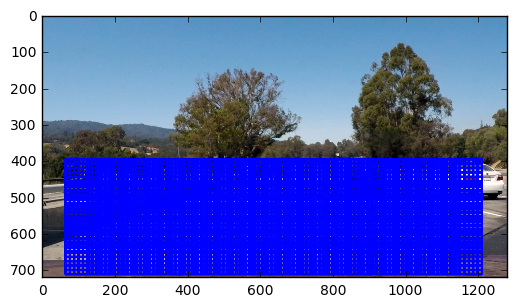

In [26]:
# sliding window parameters
window_params = {
    'x_start_stop': [np.int(example_test_image.shape[1]*0.05), np.int(example_test_image.shape[1]*0.95)],
    'y_start_stop': [np.int(example_test_image.shape[0]*0.55), example_test_image.shape[0]],
    'xy_windows': [(64,64)],
    'xy_overlap': [0.8, 0.8],
}

# example image
example = image_utils.imread("test_images/test1.jpg")

# compute sliding windows
windows = image_utils.slide_window(example, **window_params)

plt.imshow(image_utils.draw_boxes(example, bboxes=windows))

In the image above you can see the region and settings that I have selected for the sliding windows. I am only considering the region of the image where cars are likely to be and ignoring anything above the horizon. I am also overlapping the boxes by 80% so that many positives classifications will occur over vehicles. This should improve the effectiveness of thresholding later on.

#### Step 2

Now the trained SVC needs to be applied to each of the windows produced by the sliding window method. The result should be only the windows that yielded a positive classification.

The method used to perform this is provided below.

```python
def search_windows(img, windows, clf, scaler, cspace='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = feature_extraction.extract_feature(
            test_img, cspace=cspace, spatial_size=spatial_size,
            hist_bins=hist_bins, hist_range=hist_range, orient=orient,
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
            hog_channel=hog_channel, spatial_feat=spatial_feat,
            hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows
```

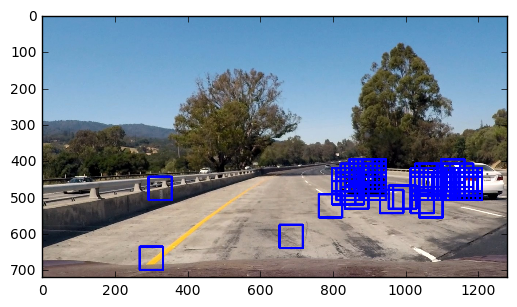

In [27]:
with open("trained-linear-svc.p", "rb") as f:
    clf = pickle.load(f)
with open("fit-scaler.p", "rb") as f:
    scaler = pickle.load(f)
with open("feature_params.p", "rb") as f:
    feature_params = pickle.load(f)

on_windows = image_utils.search_windows(img, windows=windows, clf=clf, scaler=scaler, **feature_params)
plt.imshow(image_utils.draw_boxes(example, bboxes=on_windows))

Here you can see that the classifier does a good job of identifying the two cars. It also generates a couple false positives. The next step is to generate a heatmap and threshold to remove the false positives.

#### Step 3 & 4

A heatmap will be genreated using the positively classified windows. A mask will be created that is initially all zeros. Each pixel within a window region will be incremented by 1.

The method to compute the heatmap is provided here.

```python
def compute_heatmap(img, bboxes):
    """
    Create mask where each element covered by a window is incremented by one.

    :param img: (ndarray) original image
    :param bboxes: (tuple) of window vertices
    :return: (ndarray) heatmap image
    """
    if len(img.shape) == 3:
        heat_mask = np.zeros_like(img[:,:,0])
    else:
        heat_mask = np.zeros_like(img)

    for bbox in bboxes:
        heat_mask[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    return heat_mask
```

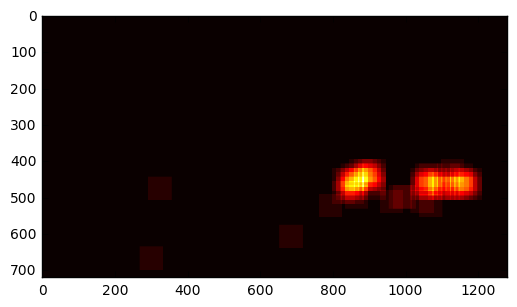

In [28]:
heatmap = image_utils.compute_heatmap(example, bboxes=on_windows)
plt.imshow(heatmap, cmap="hot")

You can see that the two cars are bright in the heatmap. Also faintly you can see two red regions in the left image that correspond to false positives. The next step involves thresholding this heatmap to remove those false positives.

The method used to threshold the image is provided below.

```python
def threshold_heatmap(heatmap, threshold):
    """
    Set all values in heatmap below specified threshold to zero.

    :param heatmap: (ndarray) heatmap of image
    :param threshold: (int) minimum element value to keep
    :return: (ndarray) thresholded heatmap
    """
    hm = heatmap.copy()
    # set all values below threshold to zero
    hm[heatmap <= threshold] = 0
    # set all values above threshold to one
    hm[hm > 0] = 1
    return hm
```

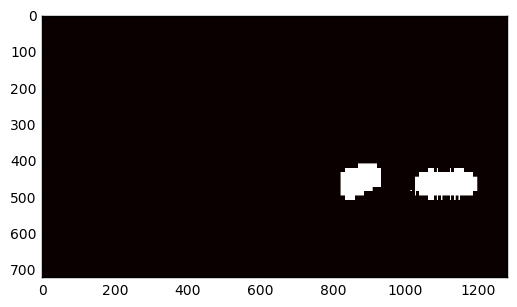

In [29]:
heatmap_th = image_utils.threshold_heatmap(heatmap, threshold=5)
plt.imshow(heatmap_th, cmap="hot")

You can see after removing all values from the heatmap that are less than 5 that the two outliers have been removed.

#### Step 5, 6, 7

Finally now that we have two discrete connected regions the cars can be identified. To do this I used a method that identifies regions of connected values.

[`skimage.measure.label`](http://scikit-image.org/docs/dev/api/skimage.measure.html#label)

This method returns an array with the same dimensions as the heatmap. The pixels of each distinct region will have a unique value associated with them. In this case the region on the left has a value of 1 and the region on the right has a value of 2.

To draw the bounding boxes I used a method that takes the labeled image and computes a bounding box around the labeled regions. This method also allows for the thresholding on the area of the regions. If a region does not achieve the minimum area threshold it is ignored.

[`skimage.measure.regionprops`](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)

The method I wrote that does this is provided below.

```python
def draw_bounding_boxes(heatmap, image, min_area=4000):
    """
    Determine bounding boxes from filtered heat map.

    Arguments:
        heatmap (ndarray): heat map
        image (ndarray): original image
        min_area (int): minimum area of blob to keep

    Returns:
        image with bounding boxes drawn around cars
    """
    # assign number to blobs label image regions
    label_image, num_cars = label(input=heatmap, return_num=True)

    bboxes = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= min_area:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            bboxes.append(((minc, minr), (maxc, maxr)))

    return draw_boxes(img=image, bboxes=bboxes)
```

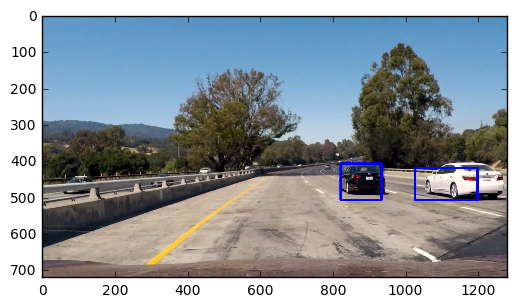

In [30]:
output = image_utils.draw_bounding_boxes(heatmap=heatmap_th, image=example)
plt.imshow(output)

Using the heatmap threshold and the minimum area threshold the pipeline is able to correctly draw bounding boxes around the two cars.

### Combining individual steps into a pipeline

Now that the individual steps have been ironed out it is time to create the pipeline. In the section below I experimentally determined the best thresholds using the test images.

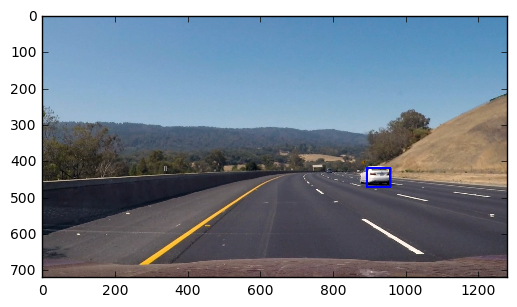

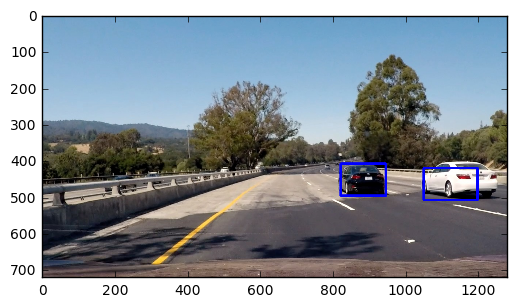

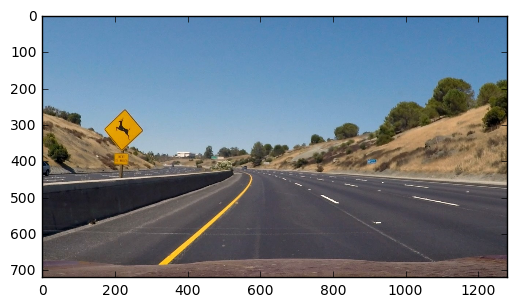

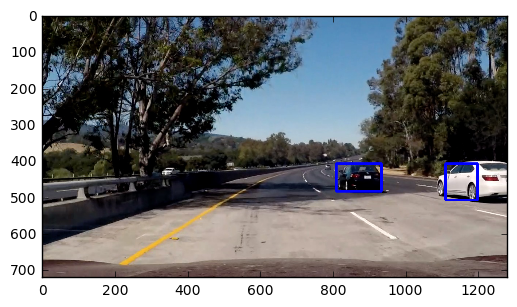

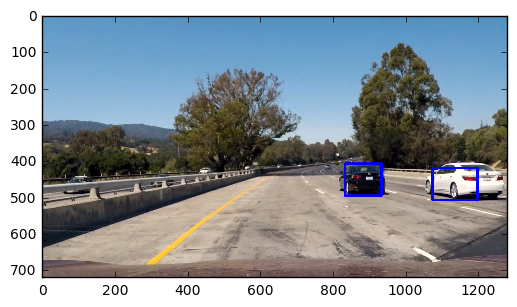

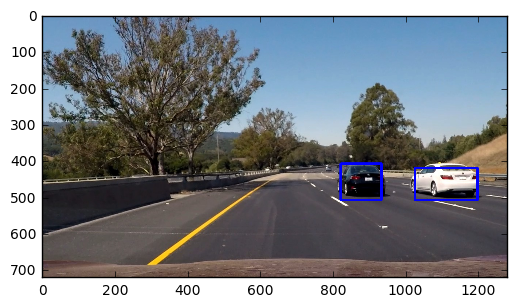

In [16]:
with open("trained-linear-svc.p", "rb") as f:
    clf = pickle.load(f)
with open("fit-scaler.p", "rb") as f:
    scaler = pickle.load(f)
with open("feature_params.p", "rb") as f:
    feature_params = pickle.load(f)
    
example_test_image = image_utils.imread("test_images/test4.jpg")

window_params = {
    'x_start_stop': [np.int(example_test_image.shape[1]*0.05), np.int(example_test_image.shape[1]*0.95)],
    'y_start_stop': [np.int(example_test_image.shape[0]*0.55), example_test_image.shape[0]],
    'xy_windows': [(64,64)],
    'xy_overlap': [0.8, 0.8],
}

for img in [image_utils.imread(i) for i in glob.glob("test_images/*.jpg")]:
    windows = image_utils.slide_window(img, **window_params)
    on_windows = image_utils.search_windows(img, windows=windows, clf=clf, scaler=scaler, **feature_params)
    heatmap = image_utils.compute_heatmap(img=img, bboxes=on_windows)
    heatmap = image_utils.threshold_heatmap(heatmap, threshold=5)
    output = image_utils.draw_bounding_boxes(heatmap, img, min_area=3000)
    # plot output
    plt.figure()
    plt.imshow(output)

The pipeline performs well on all of the test images. At this point I am going to lock down the parameters that were used to achieve this.

### Consolidate pipeline into single method

I have created a class that implements in the entire pipeline in its call method. 

```python
class VehicleDetector(object):

    def __init__(self, classifier, scaler, window_params, feature_params, consider_hist=True):
        # classification parameters
        self.clf = classifier
        self.scaler = scaler
        self.window_params = window_params
        self.feature_params = feature_params

        # cache windows from previous frame
        self.consider_hist = consider_hist
        self.window_history = []
        self.frames = 5

    def __call__(self, image):
        """
        This implements the vehicle detection pipeline.

        1. Generate windows to apply classifier in.
        2. Apply classifier to each window and store positive classifications.
        3. Generate heatmap from positive classification windows
        4. Threshold heatmap to remove noise and false positives.
        5. Draw bounding boxes around car regions.

        :param image: (ndarray) RGB image
        :param classifier: sklearn model
        :param scaler: sklearn scalerConso
        :return: (ndarray) image with bounding boxes around cars
        """
        imcpy = image.copy()
        # compute bounding boxes that classifier will be applied to
        windows = utils.slide_window(imcpy, **self.window_params)
        # apply classifier to image and return positive classifications
        on_windows = utils.search_windows(img=imcpy, windows=windows, clf=self.clf, scaler=self.scaler, **self.feature_params)
        # use previous frames to generate heatmap
        if self.consider_hist:
            # cache windows
            self.window_history.append(on_windows)
            # generate heatmap using windows from last n frames
            heatmap = np.zeros_like(image[:,:,0])
            for bboxes in self.window_history[-self.frames:]:
                # compute heatmap from positive classification windows
                heatmap += utils.compute_heatmap(imcpy, bboxes=bboxes)
        else:
            # only use current frame to generate heat map
            heatmap = utils.compute_heatmap(imcpy, bboxes=on_windows)
        # threshold heatmap
        heatmap = utils.threshold_heatmap(heatmap, threshold=5)
        # identify individual cars from heatmap
        return utils.draw_bounding_boxes(heatmap, imcpy, min_area=3000)
```

Now lets do a quick test to ensure the pipeline implementation yields the same results as above.

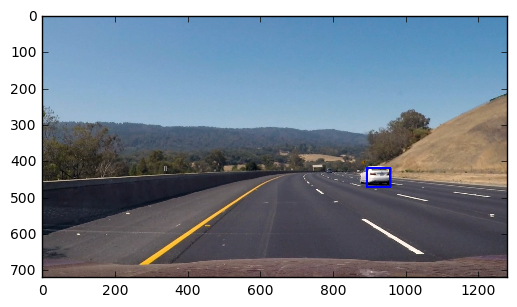

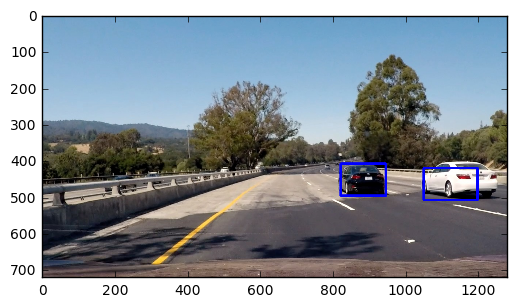

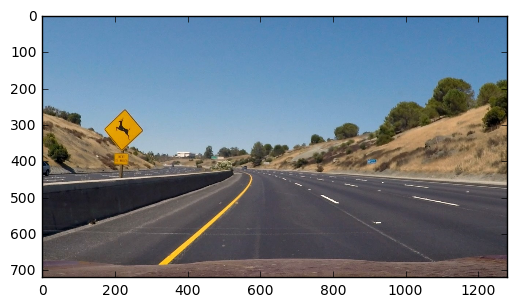

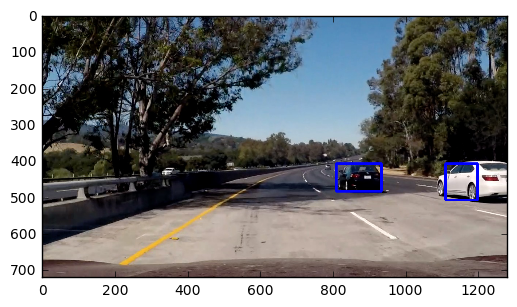

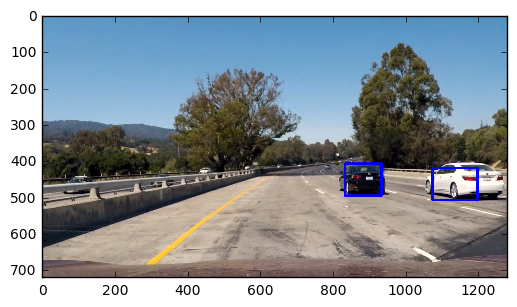

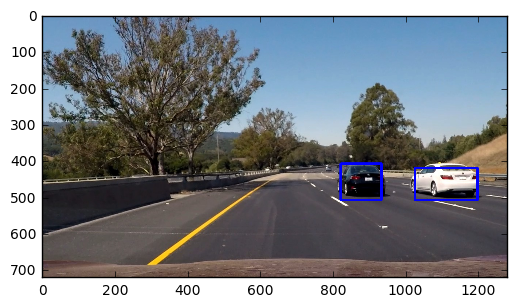

In [9]:
from libp5.pipeline import VehicleDetector

with open("trained-linear-svc.p", "rb") as f:
    clf = pickle.load(f)
with open("fit-scaler.p", "rb") as f:
    scaler = pickle.load(f)
with open("feature_params.p", "rb") as f:
    feature_params = pickle.load(f)
with open("window_params.p", "rb") as f:
    window_params = pickle.load(f)
    
vd = VehicleDetector(classifier=clf, scaler=scaler, window_params=window_params, feature_params=feature_params, consider_hist=False)

for img_path in glob.glob("test_images/*.jpg"):
    img = image_utils.imread(img_path)
    plt.figure()
    plt.imshow(vd(img))

Looks good, now it is time to apply this to the test video and finally the project video.

### Apply pipeline to test video

In [15]:
from moviepy.editor import VideoFileClip
from libp5.pipeline import VehicleDetector

# load algorithm parameters
with open("trained-linear-svc.p", "rb") as f:
    classifier = pickle.load(f)
with open("fit-scaler.p", "rb") as f:
    scaler = pickle.load(f)
with open("feature_params.p", "rb") as f:
    feature_params = pickle.load(f)
with open("window_params.p", "rb") as f:
    window_params = pickle.load(f)

# instantiate video detector with algorithm parameters
vd = VehicleDetector(classifier, scaler, window_params=window_params, feature_params=feature_params, consider_hist=False)

video_output = 'test_output.mp4'
clip = VideoFileClip("test_video.mp4")

output_clip = clip.fl_image(vd) #color images only
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:06<04:03,  6.40s/it]

  5%|▌         | 2/39 [00:12<03:58,  6.44s/it]

  8%|▊         | 3/39 [00:19<03:51,  6.43s/it]

 10%|█         | 4/39 [00:25<03:44,  6.40s/it]

 13%|█▎        | 5/39 [00:32<03:40,  6.49s/it]

 15%|█▌        | 6/39 [00:38<03:33,  6.46s/it]

 18%|█▊        | 7/39 [00:45<03:25,  6.43s/it]

 21%|██        | 8/39 [00:51<03:18,  6.41s/it]

 23%|██▎       | 9/39 [00:57<03:12,  6.42s/it]

 26%|██▌       | 10/39 [01:04<03:05,  6.40s/it]

 28%|██▊       | 11/39 [01:10<02:59,  6.41s/it]

 31%|███       | 12/39 [01:17<02:52,  6.40s/it]

 33%|███▎      | 13/39 [01:24<02:52,  6.65s/it]

 36%|███▌      | 14/39 [01:30<02:45,  6.62s/it]

 38%|███▊      | 15/39 [01:37<02:36,  6.53s/it]

 41%|████      | 16/39 [01:44<02:36,  6.80s/it]

 44%|████▎     | 17/39 [01:51<02:28,  6.74s/it]

 46%|████▌     | 18/39 [01:58<02:21,  6.75s/it]

 49%|████▊     | 19/39 [02:05<02:18,  6.94s/it]

 51%|█████▏    | 20/39 [02:13<02:17,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 4min 28s, sys: 972 ms, total: 4min 29s
Wall time: 4min 32s


I have uploaded the video to youtube for easy viewing. Overall it performs decently well.

[Test Output Video](https://youtu.be/LkPYxqS4gKQ)

### Apply pipeline to project video

In [12]:
from moviepy.editor import VideoFileClip
from libp5.pipeline import VehicleDetector

# load algorithm parameters
with open("trained-linear-svc.p", "rb") as f:
    classifier = pickle.load(f)
with open("fit-scaler.p", "rb") as f:
    scaler = pickle.load(f)
with open("feature_params.p", "rb") as f:
    feature_params = pickle.load(f)
with open("window_params.p", "rb") as f:
    window_params = pickle.load(f)

# instantiate video detector with algorithm parameters
vd = VehicleDetector(classifier, scaler, window_params=window_params, feature_params=feature_params, consider_hist=False)

video_output = 'project_output.mp4'
clip = VideoFileClip("project_video.mp4")

output_clip = clip.fl_image(vd) #color images only
%time output_clip.write_videofile(video_output, audio=False, fps=5)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4




  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 1/253 [00:08<37:41,  8.98s/it]

  1%|          | 2/253 [00:16<36:14,  8.66s/it]

  1%|          | 3/253 [00:24<34:53,  8.37s/it]

  2%|▏         | 4/253 [00:32<33:55,  8.18s/it]

  2%|▏         | 5/253 [00:40<34:20,  8.31s/it]

  2%|▏         | 6/253 [00:48<33:07,  8.04s/it]

  3%|▎         | 7/253 [00:55<32:10,  7.85s/it]

  3%|▎         | 8/253 [01:04<33:32,  8.22s/it]

  4%|▎         | 9/253 [01:12<32:37,  8.02s/it]

  4%|▍         | 10/253 [01:19<31:27,  7.77s/it]

  4%|▍         | 11/253 [01:26<30:44,  7.62s/it]

  5%|▍         | 12/253 [01:35<32:20,  8.05s/it]

  5%|▌         | 13/253 [01:42<30:45,  7.69s/it]

  6%|▌         | 14/253 [01:51<31:48,  7.99s/it]

  6%|▌         | 15/253 [02:00<33:06,  8.35s/it]

  6%|▋         | 16/253 [02:08<32:18,  8.18s/it]

  7%|▋         | 17/253 [02:15<31:00,  7.89s/it]

  7%|▋         | 18/253 [02:22<30:04,  7.68s/it]

  8%|▊         | 19/253 [02:32<32:11,  8.26s/it]

  8%|▊         |

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 32min 40s, sys: 18.2 s, total: 32min 58s
Wall time: 33min 21s


I have uploaded the video to youtube for easy viewing. Overall it performed decently well.

[Project Output Video](https://youtu.be/eCMTqNkjNfU)

## Discussion

Overall, this has been a very challenging project. I have spent countless hours trying to identify the optimal parameters that yield the fewest false positives. The solution that I have provided performs adequately but is no where near what would be required for real-time operation.

**Challenges**

- In each frame I am computing the feature vector for 3600 images which is rather slow. Computing the hog on the entire image and using subsampling would greatly improve this.
- The classifer is not as accurate as I would have liked. I want to explore using deep learning to segment the images using the U-net architecture and the crowdAI dataset.
- It is challenging to filter out all of the false positive classifications.

**Future Plans**

- I really want to explore using deep learning to perform this task end-to-end. The architecture proposed in this [paper](https://arxiv.org/pdf/1505.04597.pdf) looks really promising. The classifier should also be much more robust to perturbations in the image.
- I will also add the advanced lane finding pipeline to this project so that both vehicles and the lanes are highlighted.